# Проект по определению возраста посетителей супермаркета
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.\
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
 
**Цель:** построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Целевая ошибка - менее 8 лет (MAE < 8)

# Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#load labeles & generator
path = '/datasets/faces'
labels = pd.read_csv('{}/labels.csv'.format(path))
datagen = ImageDataGenerator(rescale=1./255) 

In [3]:
#load images as array
datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                directory = '/datasets/faces/final_files',
                                x_col = 'file_name',
                                y_col = 'real_age',
                                batch_size=16,
                                class_mode='raw',
                                seed=12345)

Found 7591 validated image filenames.


Итого у нас имеются около 7,5 тысяч изображений людей разных возрастов. На данном этапе мы не знаем, какое распределение возраста в нашей выборке, но следует отметить, что датасет весьма небольшой, особенно для задачи регрессии: если мы условно предположим, что люди каждого года от 0 до 100 лет в выборке распределены равномерно, то получится по 7 наблюдений на каждый год, что значительно ухудшает "образовательные" способности датасета. Конечно, нормальное возрастное распределение в популяции не соответствует указанному примеру, но налицо проблема небольшого количества наблюдений на условную единиц возраста. Если отсутствует возможность увеличения датасета, то наилучшим решением представляется разбиение датасета на группы, позволяющие включить большее число наблюдений в каждую категорию (скажем, от 0 до 8 лет, от 8 до 16 и т.д., исходя из заданной величины MAE). Тогда задача трансформируется в задачу классификации. 

Качество такой задачи можно будет оценить, сравнив MAE предсказаний и реального возраста каждой категории. Если предположить, что для достижения качества необходимо примерно 1000 фотографий на класс, то, исходя из величины допустимой ошибки, и максимального возраста участников фотосета (120 лет), нам требуется 15 классов или 15 000  фотографий. Это в 2 раза больше чем у нас есть. Увеличить датасет у нас нет возможности, но есть возможность продублировать изображения путем отражения.

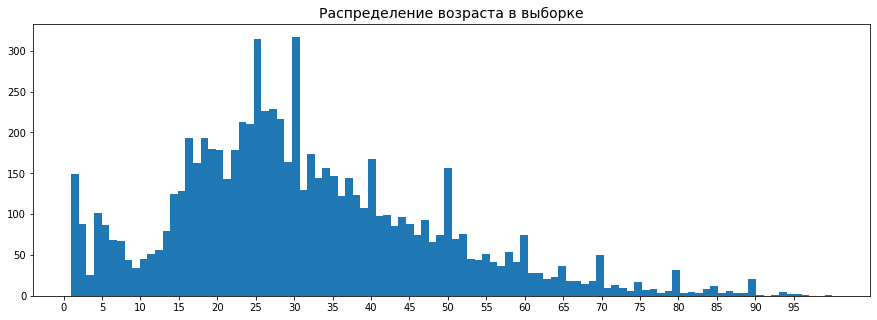

In [4]:
#print age plot
plt.figure(figsize=[15,5])
plt.hist(labels['real_age'], bins = 100)
plt.xticks(range(0,100,5))
plt.title("Распределение возраста в выборке", fontsize=14)
plt.show()

Распределение данных в выборке близко к нормальному, за исключением "пиков" на возрастах 25 и далее на "круглых" датах, таких как 30, 40 и 50 и так далее лет (возможно связано с "юбилейным" характером указанных дат), а также достаточно занчительным количеством детских (до 5-6 лет) фотографий. Это объясняется тем, что данные брались из открытых интернет-источников, где ожидаемо преобладает молодежь и дети в качестве пользователей. Это значит, что у модели будет меньше образцов фотографий людей старше 60 лет и можно ожидать чуть большую ошибку на определении возраста в данном диапазоне. С дргуой стороны, ошибка в 8 лет как раз менее значительна для маркетингового исследования на диапазоне возраста 60+, а для возраста менее 30 лет ошибка достаточно критична для формирования предсказаний, особенно касаемо продажи алкоголя.

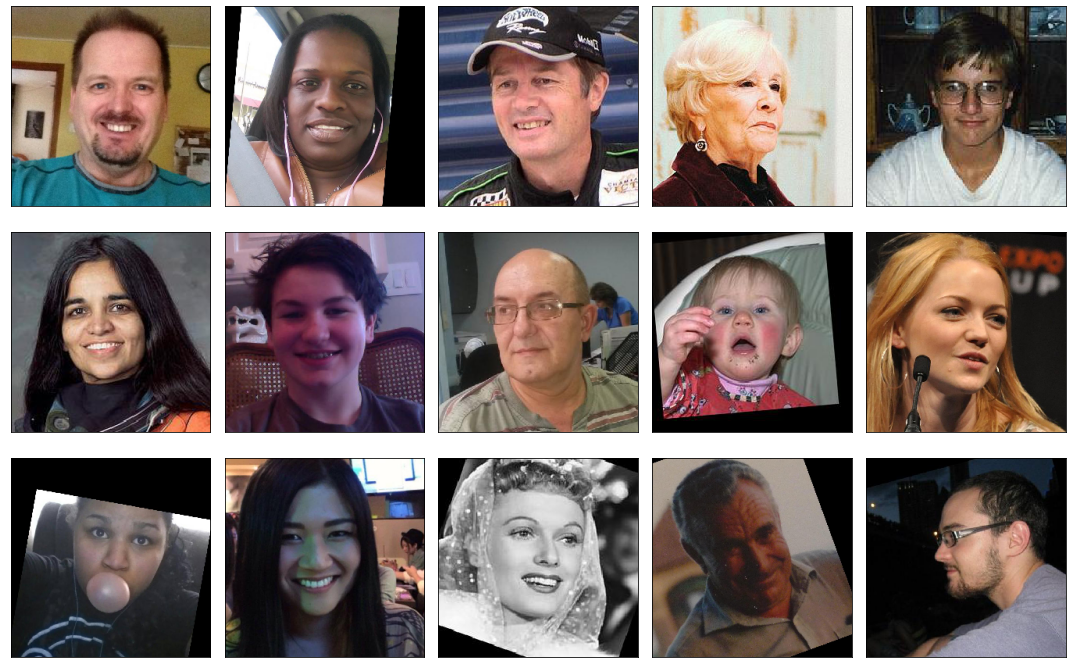

In [5]:
# print some images (15)
features, target = next(datagen_flow)
fig = plt.figure(figsize=(15,10))
for i in range(15):
        fig.add_subplot(3, 5, i+1)
        plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

Выведенные фотографии говорят нам о том, что используется преимущественно фотографии, где выполнена обрезка и выделение именно области фотографии с лицом так, чтобы лицо занимало не менее трети изображения. Фотографии при этом используются как знаменитостей, так и обычных пользователей, причем у последних лицо чаще в анфас ("селфи"), но без ретуши. Такие фотографии ценнее с точки зрения обучения модели, т.к. поступающие в реальности фотографии будут по качеству близки именно к таким изображениям или даже хуже.\

В целом на фотографиях представлены разные возрастные категории, разные наклоны фотографий и не все фотографии сделаны в анфас, т.е. на части фотографий для модели будет доступна только какая-то часть лица. Это также приближает условия для обучения модели ближе к реальным.

## Обучение модели
Напишем функции для обучения и загрузки моделей.

In [7]:
def load_train(path):
    #load labeles
    labels = pd.read_csv('{}/labels.csv'.format(path))
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255,
                                        horizontal_flip=True)
   #load images as array
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                               directory = path,
                                               x_col = 'file_name',
                                               y_col = 'real_age',
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='training',
                                               seed=12345)
    
     
    return train_datagen_flow

In [8]:
def load_test(path):
    labels = pd.read_csv('{}/labels.csv'.format(path))
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                               directory = path,
                                               x_col = 'file_name',
                                               y_col = 'real_age',
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=12345)
    
     
    return test_datagen_flow

In [9]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    # extract backbone of ResNet, take away it`s top layers (GlobalAverage... and Dense) for training our own
    backbone = ResNet50(input_shape=input_shape,
                    # that`s a way to weights of ResNet on training (for speeding, original 'imagenet')
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    #no frozen command because our dataset is big enough
    model = Sequential()
    #put backbone
    model.add(backbone)
    #put new layers for training
    model.add(GlobalAveragePooling2D())
    # output layer with 1 neuron (because it is regression task)
    model.add(Dense(1, activation='relu')) 
        
    
    model.compile(loss='mse', 
              optimizer=optimizer, metrics=['mae'])

    
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

Train for 356 steps, validate for 119 steps\
Epoch 1/15\
2023-02-04 21:54:11.140691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10\
2023-02-04 21:54:11.488509: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7\
356/356 - 70s - loss: 208.8326 - mae: 10.4427 - val_loss: 602.9861 - val_mae: 19.5202\
Epoch 2/15\
356/356 - 78s - loss: 85.1529 - mae: 6.9586 - val_loss: 187.5526 - val_mae: 10.8355\
Epoch 3/15\
356/356 - 81s - loss: 59.3165 - mae: 5.8788 - val_loss: 112.6669 - val_mae: 7.9693\
Epoch 4/15\
356/356 - 79s - loss: 44.7348 - mae: 5.0858 - val_loss: 83.2217 - val_mae: 6.8614\
Epoch 5/15\
356/356 - 79s - loss: 35.1547 - mae: 4.5391 - val_loss: 77.5183 - val_mae: 6.6720\
Epoch 6/15\
356/356 - 82s - loss: 28.3276 - mae: 4.0791 - val_loss: 72.0368 - val_mae: 6.2589\
Epoch 7/15\
356/356 - 82s - loss: 21.6814 - mae: 3.5805 - val_loss: 79.1389 - val_mae: 6.9020\
Epoch 8/15\
356/356 - 80s - loss: 17.7974 - mae: 3.2274 - val_loss: 67.8500 - val_mae: 6.1035\
Epoch 9/15\
356/356 - 81s - loss: 16.5148 - mae: 3.1206 - val_loss: 63.6266 - val_mae: 6.0379\
Epoch 10/15\
356/356 - 80s - loss: 14.9208 - mae: 2.9497 - val_loss: 64.2979 - val_mae: 6.0192\
Epoch 11/15\
356/356 - 80s - loss: 12.6626 - mae: 2.6971 - val_loss: 61.0409 - val_mae: 5.8973\
Epoch 12/15\
356/356 - 80s - loss: 11.2220 - mae: 2.5491 - val_loss: 58.4891 - val_mae: 5.7947\
Epoch 13/15\
356/356 - 81s - loss: 10.7027 - mae: 2.4789 - val_loss: 57.9492 - val_mae: 5.7182\
Epoch 14/15\
356/356 - 82s - loss: 11.1702 - mae: 2.5524 - val_loss: 62.0160 - val_mae: 5.8241\
Epoch 15/15\
356/356 - 50s - loss: 11.5945 - mae: 2.6084 - val_loss: 60.1179 - val_mae: 5.7310\
WARNING:tensorflow:sample_weight modes were coerced from\
  ...\
    to  \
  ['...']\
119/119 - 10s - loss: 60.1179 - mae: 5.7310\
Test MAE: 5.7310

## Анализ обученной модели

Разберем полученную модель и результат.

### Используемая архитектура
Для достижения полученного результата в качестве основы использовалась сеть ResNet50, предобученная на датасете Imagenet, содержащая порядка 23 млн. параметров. Далее были исключены последние слои (пулинг и полносвязный слой с 1000 классами датасета Imagenet) и заменены на наши слои (пулинг и полносвязный слой с 1 нейроном, т.к. наша задачаотносится к регрессии, а не классификации). Такая архитектура позволяет повысить скорость обучения и точность модели, т.к. модель не обучается с нуля, не нужно находить необходимый баланс весов, тем более что наш датасет недостаточно крупный для такой задачи.

### Процесс обучения модели
заложенные параметры модели:
 - 15 эпох;
 - размер батча - 16;
 - оптимизатор ADAM с шагом 0,001;
 - аугментация применена только в отношении горизонтального отражения фотографий.
 
### Достигнутый результат


Итого нам удалось достичь значения MAE в 5,73 года. Это позволяет сделать умеренно точное предсказание для маркетингового анализа, но следует отметить, что в отношении групп населения в пределах до 25 лет для контроля добросовестности касссиров при продаже алкоголя этой точности недостаточно. Следует отметить, что увеличение количества слоев или эпох обучения приводит модель к переобучению модели и для увеличения точности необходимо увеличение датасета.

Следует отдельно отметить, что обучение модели можно было остановить на 13ой эпохе, т.к. после этого момента наметилась тенденция к переобучению. Разница между минимумом и зафиксированным результатам нематериальна (0,02 года), но она хорошо отражает сложности использования предобученных моделей для дальнейшего обучения на небольших датасетах, необходимо аккуратно подходить к длительности обучения и количеству слоев для достижения результата.